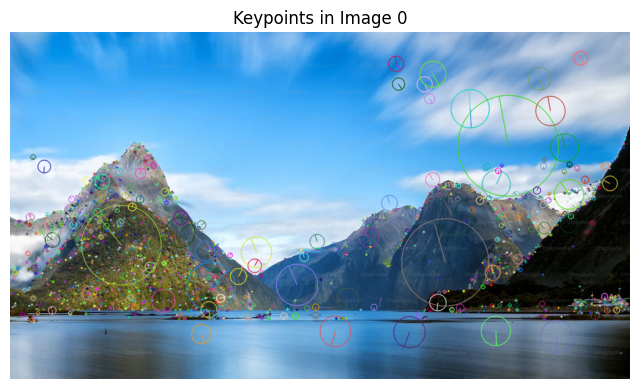

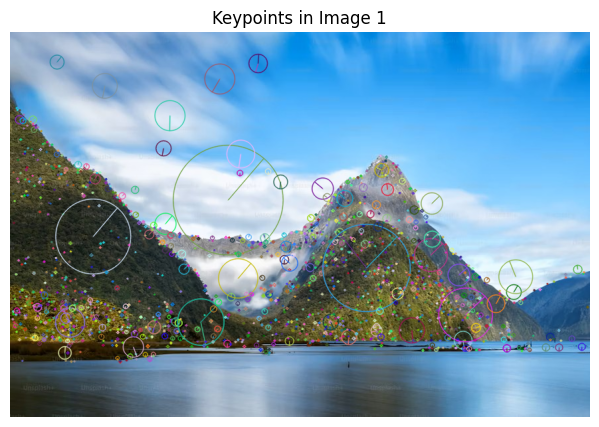

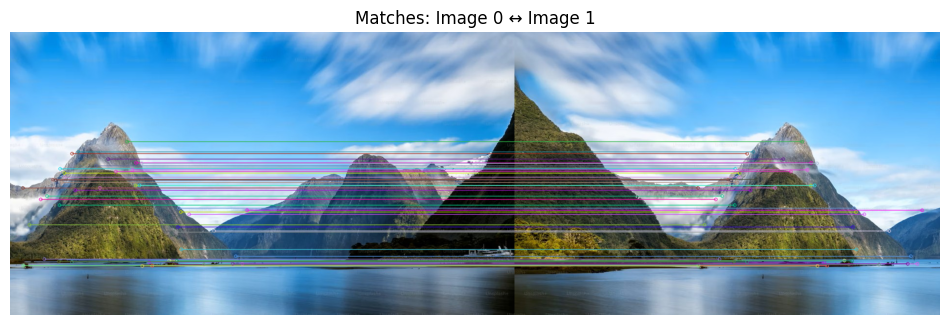

🧭 Anchor 중심 이미지 index: 0


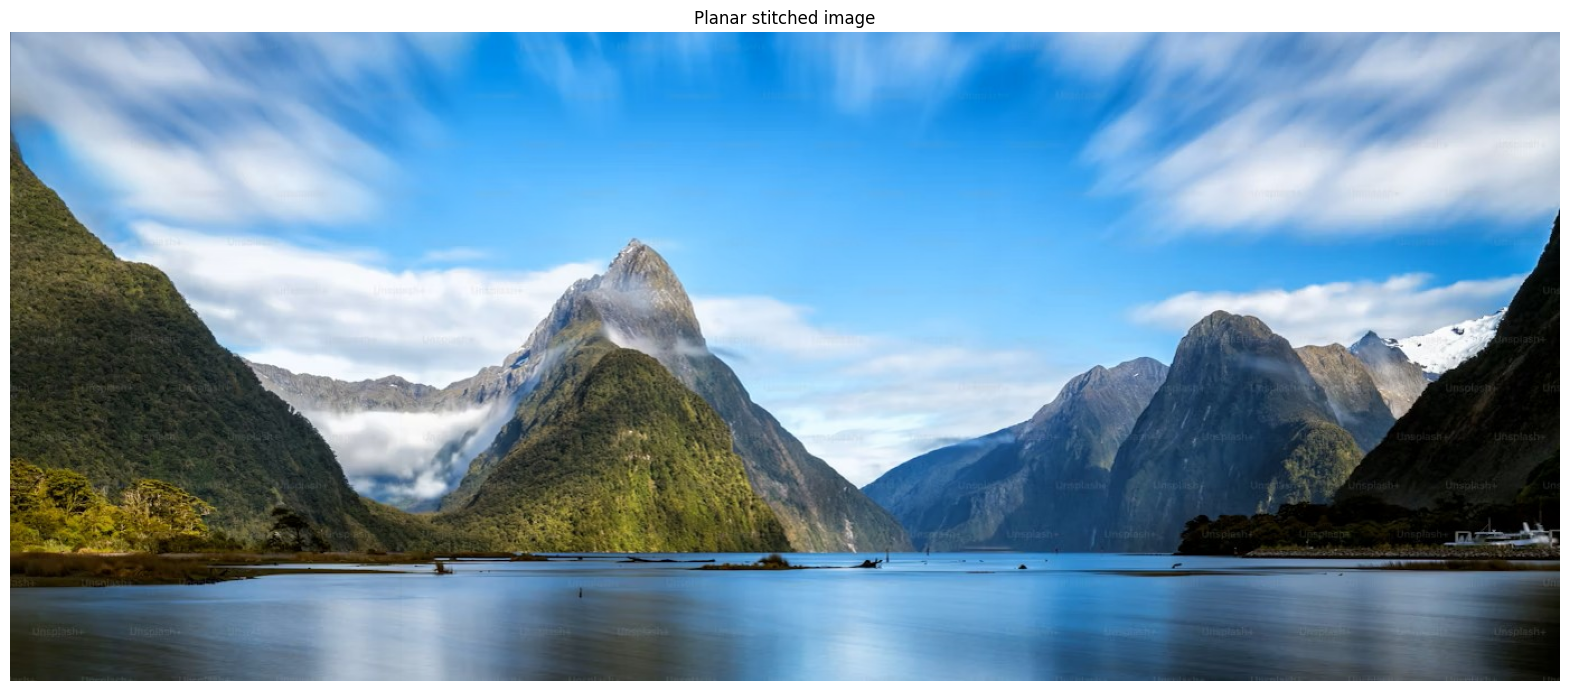

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# (1) 이미지 로드
def load_images(folder_path):
    image_paths = sorted([
        os.path.join(folder_path, fname) for fname in os.listdir(folder_path)
        if fname.lower().endswith(('.jpg', '.png', '.jpeg'))
    ])
    images = [cv2.imread(path) for path in image_paths]
    return images, image_paths

# (2) 특징 추출 시각화
def extract_features_with_vis(images):
    sift = cv2.SIFT_create()
    features = []
    for idx, img in enumerate(images):
        kp, desc = sift.detectAndCompute(img, None)
        vis = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.figure(figsize=(8, 5))
        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        plt.title(f"Keypoints in Image {idx}")
        plt.axis("off")
        plt.show()
        features.append((kp, desc))
    return features

# (3) 특징점 매칭
def match_keypoints(desc1, desc2, top_k=50):
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(desc1, desc2, k=2)
    good = [m for m, n in matches if m.distance < 0.7 * n.distance]
    return sorted(good, key=lambda x: x.distance)[:top_k]

# (4) 매칭 시각화
def draw_match_vis(img1, kp1, img2, kp2, matches, idx1, idx2):
    match_vis = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2)
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(match_vis, cv2.COLOR_BGR2RGB))
    plt.title(f"Matches: Image {idx1} ↔ Image {idx2}")
    plt.axis("off")
    plt.show()

# (5) Feather blending
def feather_blend(base, new):
    base_mask = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY) > 0
    new_mask = cv2.cvtColor(new, cv2.COLOR_BGR2GRAY) > 0
    dist_base = cv2.distanceTransform(base_mask.astype(np.uint8), cv2.DIST_L2, 5)
    dist_new = cv2.distanceTransform(new_mask.astype(np.uint8), cv2.DIST_L2, 5)
    alpha = np.zeros_like(dist_base, dtype=np.float32)
    alpha[new_mask & ~base_mask] = 1.0
    alpha[base_mask & ~new_mask] = 0.0
    overlap = base_mask & new_mask
    denom = dist_new[overlap] + dist_base[overlap] + 1e-6
    alpha[overlap] = dist_new[overlap] / denom
    alpha = cv2.GaussianBlur(alpha, (0, 0), sigmaX=3, sigmaY=3, borderType=cv2.BORDER_REPLICATE)
    alpha_3 = alpha[..., None]
    blended = (base.astype(np.float32) * (1 - alpha_3) +
               new.astype(np.float32) * alpha_3).astype(np.uint8)
    return blended

# (6) 코너 변환
def get_transformed_corners(img, H):
    h, w = img.shape[:2]
    corners = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)
    return cv2.perspectiveTransform(corners, H)

# (7) 원통형 투영
def cylindrical_projection(img, f):
    h, w = img.shape[:2]
    K = np.array([[f, 0, w / 2],
                  [0, f, h / 2],
                  [0, 0, 1]], dtype=np.float32)
    x_map = np.zeros((h, w), dtype=np.float32)
    y_map = np.zeros((h, w), dtype=np.float32)
    for y in range(h):
        for x in range(w):
            theta = (x - w / 2) / f
            h_ = (y - h / 2) / f
            X = np.array([np.sin(theta), h_, np.cos(theta)])
            proj = K @ X
            proj /= proj[2]
            x_map[y, x] = proj[0]
            y_map[y, x] = proj[1]
    return cv2.remap(img, x_map, y_map, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

# (8) 유효 영역 비율
def valid_area_ratio(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.count_nonzero(gray) / gray.size

# (9) 전체 파이프라인
def directional_stitch(folder_path):
    images, _ = load_images(folder_path)
    if len(images) < 2:
        print("❌ 최소 2장의 이미지가 필요합니다.")
        return
    features = extract_features_with_vis(images)
    N = len(images)
    for i in range(N):
        for j in range(i + 1, N):
            kp1, desc1 = features[i]
            kp2, desc2 = features[j]
            matches = match_keypoints(desc1, desc2)
            draw_match_vis(images[i], kp1, images[j], kp2, matches, i, j)
    # Anchor 중심 이미지 결정
    shift_scores = {}
    for i in range(N):
        total_shift, count = 0, 0
        for j in range(N):
            if i == j: continue
            kp1, desc1 = features[i]
            kp2, desc2 = features[j]
            matches = match_keypoints(desc1, desc2)
            if len(matches) >= 4:
                src_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
                dst_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
                H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                if H is not None:
                    total_shift += abs(H[0, 2])
                    count += 1
        shift_scores[i] = total_shift / count if count > 0 else float('inf')
    anchor = min(shift_scores.items(), key=lambda x: x[1])[0]
    print(f"🧭 Anchor 중심 이미지 index: {anchor}")
    # 순서 정렬
    shift_map = {}
    for j in range(N):
        if j == anchor: continue
        kp1, desc1 = features[anchor]
        kp2, desc2 = features[j]
        matches = match_keypoints(desc1, desc2)
        if len(matches) >= 4:
            src_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
            H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            if H is not None:
                shift_map[j] = H[0, 2]
    left = sorted([j for j in shift_map if shift_map[j] < 0], key=lambda j: shift_map[j])
    right = sorted([j for j in shift_map if shift_map[j] > 0], key=lambda j: shift_map[j])
    order = left + [anchor] + right
    # Homography 적용 및 스티칭
    H_matrices = {}
    global_corners = []
    for j in order:
        if j == anchor:
            H = np.eye(3)
        else:
            kp1, desc1 = features[anchor]
            kp2, desc2 = features[j]
            matches = match_keypoints(desc1, desc2)
            src_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
            H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        H_matrices[j] = H
        corners = get_transformed_corners(images[j], H)
        global_corners.append(corners)
    all_corners = np.concatenate(global_corners, axis=0)
    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
    canvas_size = (x_max - x_min, y_max - y_min)
    translate = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]], dtype=np.float32)
    stitched_img = np.zeros((canvas_size[1], canvas_size[0], 3), dtype=np.uint8)
    for j in order:
        H = H_matrices.get(j, np.eye(3))
        warped = cv2.warpPerspective(images[j], translate @ H, canvas_size)
        stitched_img = feather_blend(stitched_img, warped)
    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(stitched_img, cv2.COLOR_BGR2RGB))
    plt.title("Planar stitched image")
    plt.axis("off")
    plt.show()

directional_stitch("C:/Users/wjdrj/Desktop/10_image_stitching/problem_1")
